In [1]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from models import *
import time
import re, io, nltk, torch 
from nltk.corpus import stopwords
from numpy import linalg as LA
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.utils.class_weight import compute_class_weight
from gensim import utils, matutils  
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from numpy import linalg as LA
from sklearn.preprocessing import Normalizer
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from scipy.stats import bernoulli
import numpy as np

import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

train =pd.read_csv("../../Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../../Fine-Tuning/CSV_Stance/test_semeval_raw.csv")


Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [2]:
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

stemmer_sn = SnowballStemmer("english")
stemmer = PorterStemmer()

stoplist = stopwords.words("english")
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post): 
    #re.sub(r'([a-z])\1+', r'\1', "user i think that ' s all you loooooove ")
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    #sl= [stemmer.stem(wd) for wd in sl]
    ############3
    sl_2=[]
    for wd in sl:
        try: 
            q=Word2Index[wd]
            sl_2.append(wd)
        except:
            try: 
                r=Word2Index[stemmer.stem(wd)]
                sl_2.append(stemmer.stem(wd))
            except:
                sl_2.append(wd)
    sl=sl_2
    ##########
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl


In [3]:
tokenizer_loaded = BertTokenizer.from_pretrained('bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)#'bert-base-uncased',  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
Word2Index=tokenizer_loaded.vocab
M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()

In [4]:
not_found=[]
found=[]
found_train=[]
pos_tag_nf=[]

MAX_LEN=50

etiq=[]
for et in train['Label'].values:
    etiq.append(d_lab[et])
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)
sentences = train['Tweet'].values
input_ids = []
i=0

for sent in sentences:
    temp=cleaner(sent)
    encoded_sent2 = tokenizer_loaded.encode(temp[0],add_special_tokens = False) 
    encoded_sent=[]
    iterar=temp[1]
    for wd in iterar:
        try:
            indice=Word2Index[wd]
            encoded_sent.append(wd)
            if wd not in found:
                found.append(wd)
                found_train.append(wd)
        except: 
            if wd not in not_found:
                not_found.append(wd)
                pos_tag_nf.append(nltk.pos_tag([wd])[0][-1])

    input_ids.append(encoded_sent2)
    """ if i<3:
        print ("-----------------------------------------------------------------")
        print ("\nsentencia original:", sent)
        #print ("\nsentencia procesada My cleaner:",temp[0])
        print ("\nsentencia tokenizada usando Transformer vocabulary:", encoded_sent)
        print ("\nsentencia tokenizada usando Transformer Tokenizer:", encoded_sent2)
    i+=1"""

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")



In [5]:
etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
i=0
for sent in sentences_val:
    temp=cleaner(sent)
    encoded_sent2 = tokenizer_loaded.encode(temp[0],add_special_tokens = False) 
    encoded_sent=[]
    iterar=temp[1]
    for wd in iterar:
        try:
            indice=Word2Index[wd]
            encoded_sent.append(wd)
            if wd not in found: 
                found.append(wd)
        except: 
            if wd not in not_found:
                not_found.append(wd)
                pos_tag_nf.append(nltk.pos_tag([wd])[0][-1])
            
    input_ids_val.append(encoded_sent2)
    """if i<3:
        print ("-----------------------------------------------------------------")
        print ("\nsentencia original:", sent)
        #print ("\nsentencia procesada My cleaner:",temp[0])
        print ("\nsentencia tokenizada usando Transformer vocabulary:", encoded_sent)
        print ("\nsentencia tokenizada usando Transformer Tokenizer:", encoded_sent2)
    i+=1"""
    
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")


etiq_t=[]
for et in test['Label'].values:
    etiq_t.append(d_lab[et])
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
i=0
for sent in sentences_test:
    temp=cleaner(sent)
    #encoded_sent=[Word2Index[wd] for wd in temp]
    encoded_sent2 = tokenizer_loaded.encode(temp[0],add_special_tokens = False) 
    encoded_sent=[]
    iterar=temp[1]
    for wd in iterar:
        try:
            indice=Word2Index[wd]
            encoded_sent.append(wd)
            if wd not in found:
                found.append(wd)            
        except: 
            if wd not in not_found:
                #print ("not found", wd)
                not_found.append(wd)
                pos_tag_nf.append(nltk.pos_tag([wd])[0][-1])
            
    input_ids_test.append(encoded_sent2)
    """if i<3:
        print ("-----------------------------------------------------------------")
        print ("\nsentencia original:", sent)
        #print ("\nsentencia procesada My cleaner:",temp[0])
        print ("\nsentencia tokenizada usando Transformer vocabulary:", encoded_sent)
        print ("\nsentencia tokenizada usando Transformer Tokenizer:", encoded_sent2)
    i+=1"""

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")


In [6]:
len(not_found)

1910

In [7]:
print ("[my_cleaner] \t#Palabras NO encontradas en vocab BERT:",len(not_found))
print ("[my_cleaner] \t#Palabras encontradas en vocab BERT:",len(found))
print ("Distribución de palabras no encontradas en POS tag:", Counter(pos_tag_nf) )

[my_cleaner] 	#Palabras NO encontradas en vocab BERT: 1910
[my_cleaner] 	#Palabras encontradas en vocab BERT: 5168
Distribución de palabras no encontradas en POS tag: Counter({'NN': 1390, 'NNS': 220, 'VBG': 82, 'JJ': 82, 'VBN': 52, 'CD': 39, 'RB': 33, 'VBD': 5, 'VB': 4, 'JJS': 2, 'IN': 1})


In [8]:
for wd in not_found[:30]:
    print ("[",wd,"] \t\tlema:",lemmatizer.lemmatize(wd), "\tStem:",stemmer.stem(wd), "\tStem snow:", stemmer_sn.stem(wd))

[ lol ] 		lema: lol 	Stem: lol 	Stem snow: lol
[ hashtag ] 		lema: hashtag 	Stem: hashtag 	Stem snow: hashtag
[ harass ] 		lema: harass 	Stem: harass 	Stem snow: harass
[ smear ] 		lema: smear 	Stem: smear 	Stem snow: smear
[ schaut ] 		lema: schaut 	Stem: schaut 	Stem snow: schaut
[ genau ] 		lema: genau 	Stem: genau 	Stem snow: genau
[ hin ] 		lema: hin 	Stem: hin 	Stem snow: hin
[ messieurs ] 		lema: monsieur 	Stem: messieur 	Stem snow: messieur
[ gendarmes ] 		lema: gendarme 	Stem: gendarm 	Stem snow: gendarm
[ wd ] 		lema: wd 	Stem: wd 	Stem snow: wd
[ retweeted ] 		lema: retweeted 	Stem: retweet 	Stem snow: retweet
[ favourited ] 		lema: favourited 	Stem: favourit 	Stem snow: favourit
[ tweet ] 		lema: tweet 	Stem: tweet 	Stem snow: tweet
[ omg ] 		lema: omg 	Stem: omg 	Stem snow: omg
[ wouldve ] 		lema: wouldve 	Stem: wouldv 	Stem snow: wouldv
[ krauts ] 		lema: kraut 	Stem: kraut 	Stem snow: kraut
[ +&gt ] 		lema: +&gt 	Stem: +&gt 	Stem snow: +&gt
[ firedoor ] 		lema: firedoor 

In [9]:
def my_normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v/norm

#el peso max es igual a la clase mas grande
def det_samples(df, dict_class, c_weights=None):
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
    for clase in conteos:
        if conteos[clase]==maxi:
            class_maxi=clase
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            weigths=my_normalize(c_weights)
            max_wei=max(weigths)
            class_max= list(weigths).index(max_wei)
            str_class=dict_class[class_max]
            samples_max=conteos[str_class]
            
            clase=0
            for peso in weigths:
                k=dict_class[clase]
                if peso == max_wei:
                    aumentos[k]= int(samples_max-conteos[k])
                    #print ("aumentos[k]", aumentos[k], 'sampples min', samples_max, 'conteos[clase]', conteos[clase])
                else:
                    futuro=(samples_max/max_wei)*peso
                    aumentos[k]=int(futuro-conteos[k])
                    #print ("aumentos[k] para pesos no minimos ", aumentos[k], "futuro", futuro, "actual", conteos[k])
                clase+=1
            return aumentos
        except:
            print ("No se ha especificado el vector de pesos par balance de datos")
            
            
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1]))   
  
def re_generar(muestra, tags_all, tag, prob):
    sent, indices, tags = just_tag_word(muestra, tags_all, tag)
    noise_mask = bernoulli.rvs(prob, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    idx_to_orig=len(sent)
    return  to_replace , indix, tagx, idx_to_orig

puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def just_tag_word(sentence, tags_all, tag):
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if tags_all[i] not in tag:
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def all_tag_word(sentence):    
    n_sentence=[]
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            continue
        else:
            n_sentence.append(wd)    
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)
    
def all_tag_word2(sentence):
    n_sentence=[]
    for wd in sentence:
        if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
            continue
        else:
            n_sentence.append(wd)
    return np.asarray(n_sentence)
        
def check_word(token, tag, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in vocabulary[clase]:
            return True
        else: 
            return False

def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag:
            return True
        else: 
            return False
        
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    #print ("Tags de pos/neg:", lista_tag)
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags:
            keep.append(word)
    return keep
            
def my_most_similar_cosmul(space, M_BERT_space, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    #if negative is None:
    #    negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        Word2Index[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]    
    positive = [M_BERT_space[idx] for idx in ids_pos]  #space de vocab
    
    if negative is None:
        negative = []
    else: 
        #print ("\n\nSE SOLICITAN NEGATIVOS\n\n")
        ids_nega= [
            Word2Index[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
            for word in negative
        ]
        negative = [M_BERT_space[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]
    
    #pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas


def find_positive(lista, target, id_target, bias, window=4):
    to_return=[target]
    to_return=to_return*int(bias)
    positive_temp=find_window(lista, target, id_target, window=window)
    to_return+=positive_temp
    
    return to_return
                  

def find_window(lista, target, id_target, window=4):  #wind debe ser par   
    to_return=[]
    sub_w=int(window/2)
    
    if id_target >= sub_w and id_target + sub_w < len(lista):
        atras=lista[id_target-sub_w:id_target]
        adelante=lista[id_target+1:id_target+1+sub_w]
        
    elif id_target  < sub_w:
        atras=lista[:id_target]
        adelante=lista[id_target+1:id_target+sub_w+1]
        
    elif id_target + sub_w >= len(lista): 
        atras=lista[id_target-sub_w:id_target]
        adelante= lista[id_target+1:]
        
    to_return+=atras
    to_return+=adelante
    return to_return


def find_negative(target, not_sent, window=4):
    cleaned = cleaner(not_sent)[0]
    cleaned= tokenizer_loaded.tokenize(cleaned, add_special_tokens = False)
    ide = cleaned.index(target)
    wind_neg=find_window(list(cleaned), target, ide, window=window)
   
    return wind_neg


def sample_neg_class(cl):
    if type(cl) != list:
        cl = [cl]
    aux = list(d_lab.keys())
    for value in cl:
        aux.remove(value)
    samp_neg = np.random.choice(aux)
    
    used_classes = cl
    used_classes.append(samp_neg)
    return samp_neg, used_classes

def check_special(lista):
    exceptions=['[CLS]', '[SEP]', '[MASK]']
    to_return=[]
    for item in lista:  #es una tupla
        if item[0] not in exceptions: 
            to_return.append(item[0])
        else:
            continue
    return to_return

def choose_replace(candidatos, ide, target):
    candidatos=check_special(candidatos)
    try:
        candidatos.remove(target)
    except:
        pass
    
    elem=np.random.choice(candidatos)
    return (elem, ide)
        

def aumentar_clase(clase, num_ejem, tags_all, prob, TOPN):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    print ("Consultando por la clase", clase)
    label=d_lab[clase]    
    print ("Entrega label", label)
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['Tw_id'][indx]
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    pre=np.asarray(tokenizer_loaded.tokenize(cleaner(muestra)[0], add_special_tokens=False))                    
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre]
                    terms, indxs, tagx, tope_replace= re_generar(pre, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):                           
                            mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_pos[tag])
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= M_BERT_space[mask_words] #vocab de clase y tag
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(list(pre), term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4) 
                                    valid_neg=check_valid(neg, tags_all)

                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue
                                    #pass

                                best, dists_best = my_most_similar_cosmul(space, M_BERT_space, 0.0, positive=valid_pos, negative=valid_neg, topn=TOPN)
                                #best, dists_best = my_most_similar_cosmul(space, M_BERT_space, 0.0, positive=valid_pos, negative=None, topn=TOPN)

                                todo_words = {
                                    Word2Index[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in Word2Index
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:TOPN] #+2
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre[i])
                                except: 
                                    nueva_sent.append(pre[i])
                       
                            totales+=cont_new
                            new_sample.append([contador, nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre)
                            contador+=1
                            
                            #"""
                            if len(new_sample)<10:
                                print ("Sentencia original:")
                                print (pre)
                                print ("Sentencia final:" , label)
                                print (nueva_sent)
                                print ("")
                                print ("")
                            #"""                              

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre=np.asarray(cleaner(muestra)[1])
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['Tw_id'].values
        for muestra, twid in list(zip(news_tw, news_id)):
            pre=np.asarray(cleaner(muestra)[1])
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    return new_sample, dict_resumen


def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [10]:
transformer = Normalizer().fit(M_BERT_space) 
M_BERT_space=transformer.transform(M_BERT_space)

tr_s=train.loc[train['Label']=='support']
tr_d=train.loc[train['Label']=='denying']
tr_q=train.loc[train['Label']=='questioning']
tr_c=train.loc[train['Label']=='commenting']
keys=['support', 'denying', 'questioning', 'commenting']

dict_vocab={}
for key in keys: 
    tr_k=train.loc[train['Label']==key]
    tr_k=tr_k['Tweet'].values    
    trs_k=[]
    for tw in tr_k:
        encoded = cleaner(tw)[1]
        apen=[]
        for wd in encoded:
            try: 
                h=Word2Index[wd]
                apen.append(wd)
            except: 
                continue
        
        #trs_k+=list(set(encoded))
        trs_k+=apen
    dict_vocab[key]=list(set(trs_k ))
    print ("#terms ",key,":",len(dict_vocab[key]))
      


#terms  support : 1773
#terms  denying : 1219
#terms  questioning : 1043
#terms  commenting : 3790


In [11]:
all_terms=[]
for key in keys:
    all_terms+=dict_vocab[key]
    
len(set(all_terms))

4455

In [12]:
len(found_train)

4455

In [15]:
vocabulary=dict_vocab
dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train['Tweet'],train['Label']))):
    pre=np.asarray(cleaner(muestra)[1])
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)

In [13]:
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['support', 'denying', 'questioning', 'commenting']

In [16]:
d_pos= dict()
for tag in tags:
    d_pos[tag]= [check_tag(k, tag) for k in idx_2_token.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]

In [16]:
d_vocab['denying'] and d_pos['NN'][:10]

[True, False, False, False, False, False, False, False, False, False]

In [17]:
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape


(1021, 50, 768)

In [18]:
 tokenizer_loaded.encode('the dog')

[101, 1996, 3899, 102]

In [17]:
for i in range(4,6):
    print (i)

4
5


### Generar 3 en stance [pos + negativo classic]

In [18]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(4,6): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\n\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../../../new_data_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'clarified', 'that', 'earlier', '.', 'words']


Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'chance', 'that', "'", 'thought', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?']


Sentencia original:
['user' 'user' 'user' 'how' 'stupid' 'html']
Sentencia final: 2
['user', 'user', 'user', 'how', 'investigative', 'html']


Sentencia original:
['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 

# terms modificados promedio 1.719283631820075 términos por sentencia
Largo de sentencia promedio 21.93877551020408 términos por sentencia
para esta ejecución se debiesen reemplazar 5852  de 38865 terminos
Resumen de modificaciones: {'VBG': 195, 'NN': 2350, 'VB': 264, 'JJ': 364, 'NNS': 406, 'VBD': 143, 'VBP': 71, 'VBN': 135, 'VBZ': 186, 'JJR': 7, 'JJS': 7}
Este proceso tomó 26.541862726211548 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'if' 'so' 'that' 'hostage' 'will' 'be' 'the' 'person'
 'best' 'able' 'to' 'give' 'an' 'insight' 'into' 'the' 'attack' ',' 'if'
 'the' 'suspects' 'were' 'responsible' '.']
Sentencia final: 2
['user', 'user', 'if', 'so', 'that', 'hostage', 'will', 'be', 'the', 'person', 'best', 'unable'

# terms modificados promedio 1.6859641815910038 términos por sentencia
Largo de sentencia promedio 21.92628071636818 términos por sentencia
para esta ejecución se debiesen reemplazar 5773  de 39202 terminos
Resumen de modificaciones: {'NN': 2312, 'VB': 251, 'VBZ': 194, 'NNS': 405, 'VBN': 131, 'VBP': 66, 'VBD': 143, 'VBG': 207, 'JJS': 5, 'JJ': 324, 'JJR': 10}
Este proceso tomó 26.516621589660645 seg


In [16]:
prob=0.15 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../../../new_data_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../../../new_data_augmented/stance_baselines/0.15/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.973482077542063
F1-score None sobre Train cnn1 : [0.95975119 0.99029126 0.99162113 0.95217152]
F1-score macro sobre Train cnn1 : 0.9734587758615285

Accuracy sobre Val cnn1 : 0.5195729537366548
F1-score None sobre Val cnn1 : [0.42857143 0.20289855 0.68656716 0.61029412]
F1-score macro sobre Val cnn1 : 0.4820828152805574

Accuracy sobre Test cnn1 : 0.4877571008814887
F1-score None sobre Test cnn1 : [0.18791946 0.18450185 0.56       0.61324612]
F1-score macro sobre Test cnn1 : 0.3864168560534075

Accuracy sobre Train cnn2 : 0.9739392831016825
F1-score None sobre Train cnn2 : [0.9581692  0.99083578 0.99375918 0.95334398]
F1-score macro sobre Train cnn2 : 0.9740270327808604

Accuracy sobre Val cnn2 : 0.5871886120996441
F1-score None sobre Val cnn2 : [0.50666667 0.18518519 0.58823529 0.6970684 ]
F1-score macro sobre Val cnn2 : 0.49428888746957333

Accuracy sobr


Accuracy sobre Train rnn3 : 0.9385515727871251
F1-score None sobre Train rnn3 : [0.96401268 0.89939638 0.99054889 0.90077853]
F1-score macro sobre Train rnn3 : 0.938684120358987

Accuracy sobre Val rnn3 : 0.604982206405694
F1-score None sobre Val rnn3 : [0.56976744 0.13333333 0.42424242 0.68608414]
F1-score macro sobre Val rnn3 : 0.4533568354577612

Accuracy sobre Test rnn3 : 0.6591576885406464
F1-score None sobre Test rnn3 : [0.11162791 0.04878049 0.55263158 0.78576137]
F1-score macro sobre Test rnn3 : 0.37470033621405385
----------------------- Entrenando running  4 -----------------------
Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9737564008778347
F1-score None sobre Train cnn1 : [0.9589399  0.99048664 0.99117323 0.95472371]
F1-score macro sobre Train cnn1 : 0.9738308701942622

Accuracy sobre Val cnn1 : 0.604982206405694
F1-score None sobre Val cnn1 : [0.55483871 0.23076923 0.7037037  0.67774086]
F1-score macro sobre Val cnn1 : 0.5417631269844323

Accuracy sobre 

In [17]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

(0.15) app1 F1-score promedio para cnn1 : [0.15520698 0.20145702 0.55019205 0.66932097]
(0.15) app1 F1-score promedio para cnn2 : [0.15117022 0.18644543 0.47959179 0.70960705]
(0.15) app1 F1-score promedio para rnn1 : [0.14161914 0.168561   0.41043099 0.62624104]
(0.15) app1 F1-score promedio para rnn2 : [0.14805559 0.15818143 0.3682198  0.63497699]
(0.15) app1 F1-score promedio para rnn3 : [0.10681358 0.11902607 0.47685592 0.71676223]

(0.15) app1 F1-score macro promedio para cnn1 : 0.3940442540608318 desvest:  0.00978115395671879
(0.15) app1 F1-score macro promedio para cnn2 : 0.3817036209529983 desvest:  0.01638446993148148
(0.15) app1 F1-score macro promedio para rnn1 : 0.33671304313207406 desvest:  0.017775938086573947
(0.15) app1 F1-score macro promedio para rnn2 : 0.3273584517779736 desvest:  0.02893971476247099
(0.15) app1 F1-score macro promedio para rnn3 : 0.35486444849886867 desvest:  0.017207257027957865

(0.15) app1 Accuracy promedio para cnn1 : 0.5373163565132224
(0.15) a

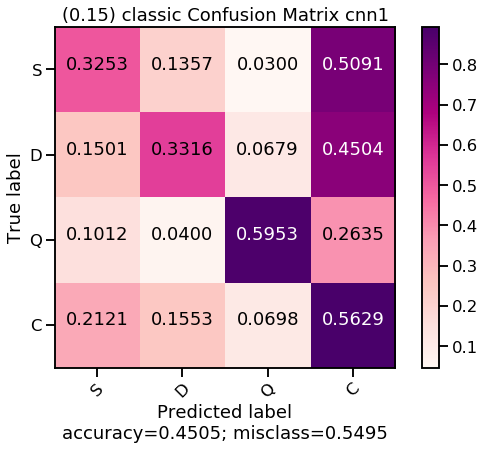

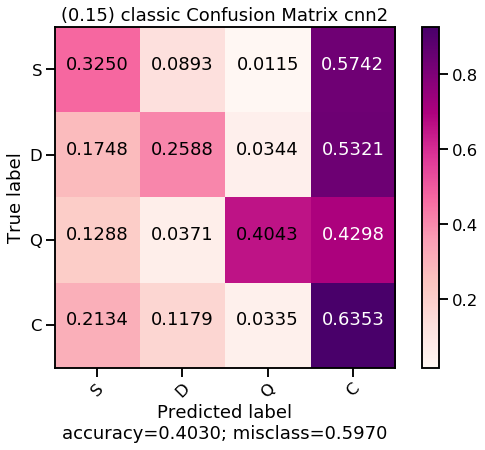

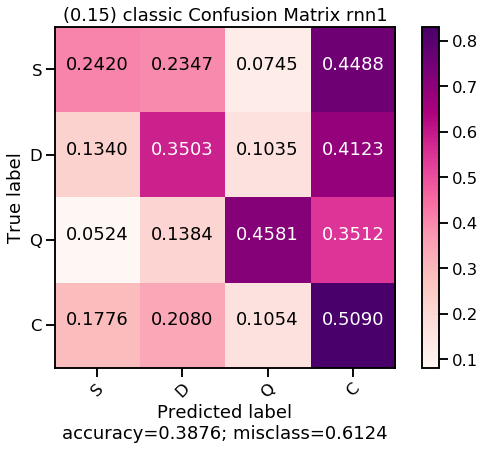

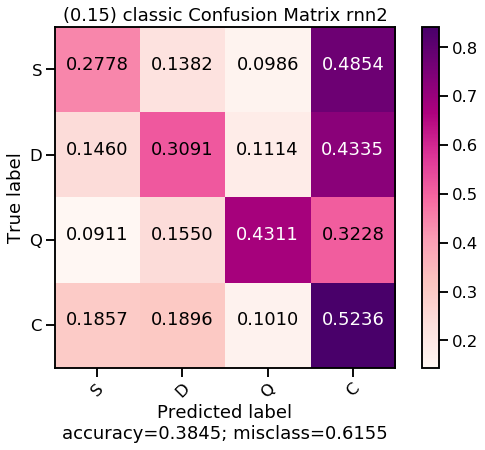

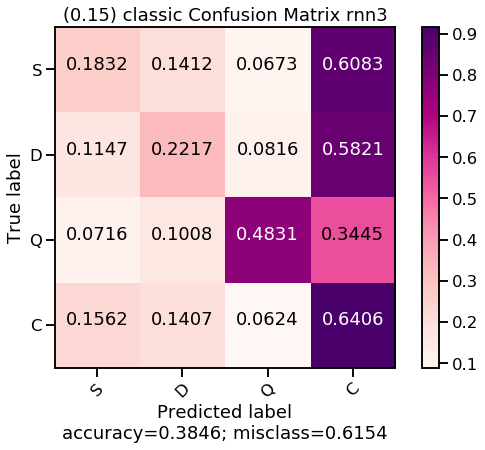

In [18]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) classic Confusion Matrix "+str(key), cmap='RdPu')

# antes

In [31]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

(0.15) app1 F1-score promedio para cnn1 : [0.16913599 0.18723455 0.49906575 0.69778321]
(0.15) app1 F1-score promedio para cnn2 : [0.16031989 0.18644776 0.51035165 0.6925465 ]
(0.15) app1 F1-score promedio para rnn1 : [0.17171842 0.19636354 0.46200435 0.58031299]
(0.15) app1 F1-score promedio para rnn2 : [0.1545045  0.1782947  0.37189671 0.66043247]
(0.15) app1 F1-score promedio para rnn3 : [0.14245492 0.1926821  0.41736885 0.6426199 ]

(0.15) app1 F1-score macro promedio para cnn1 : 0.38830487191781077 desvest:  0.006831230781057216
(0.15) app1 F1-score macro promedio para cnn2 : 0.38741645035178235 desvest:  0.014239833755777597
(0.15) app1 F1-score macro promedio para rnn1 : 0.35259982325053113 desvest:  0.019371410260679088
(0.15) app1 F1-score macro promedio para rnn2 : 0.3412820974377307 desvest:  0.03624614570128045
(0.15) app1 F1-score macro promedio para rnn3 : 0.3487814442792427 desvest:  0.013173898642341003

(0.15) app1 Accuracy promedio para cnn1 : 0.5579497224942866
(0.15

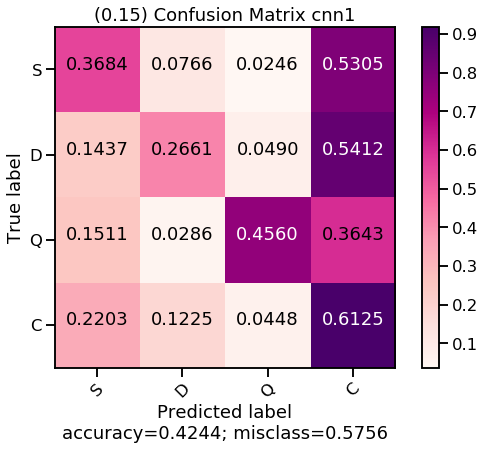

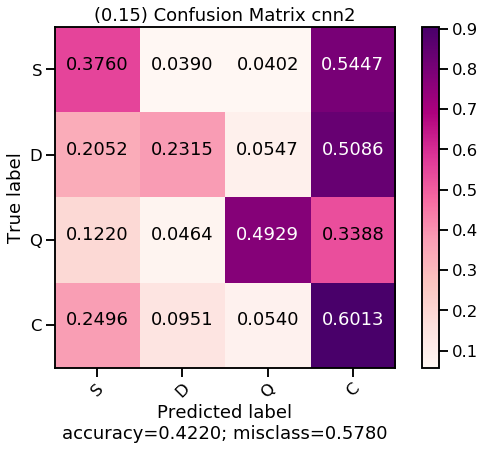

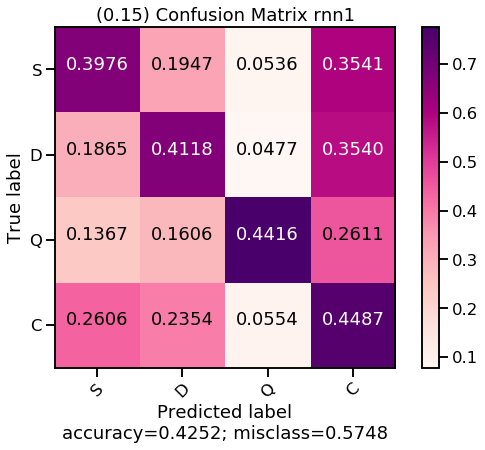

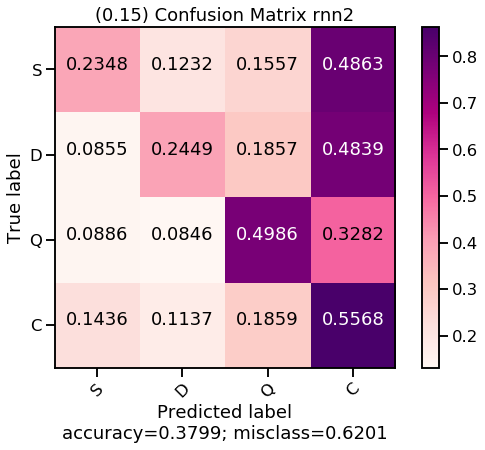

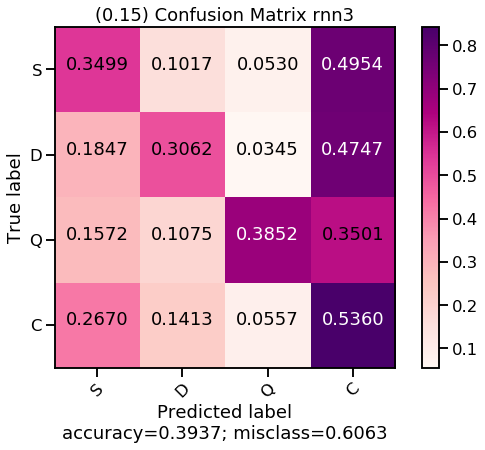

In [32]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/3.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) Confusion Matrix "+str(key), cmap='RdPu')

### Generar 3 en stance [positivo classic]

In [34]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,4): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad SIN NEG --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../../../new_data_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'_SinNeg.npy', macro_augmented)
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad SIN NEG -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'disgusted', 'that', 'earlier', '.', 'cheers']


Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'possibility', 'that', "'", 's', 'being', 'said', 'for', 'justification', 'of', 'retribution', '?']


Sentencia original:
['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 'won' "'"
 't' 'make' 'it' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'ah', 'true', '.', 'problem', 'now', 'is', 

# terms modificados promedio 1.823823406913786 términos por sentencia
Largo de sentencia promedio 21.65847563515202 términos por sentencia
para esta ejecución se debiesen reemplazar 5368  de 35860 terminos
Resumen de modificaciones: {'VBG': 212, 'NN': 2521, 'VB': 253, 'JJ': 361, 'VBN': 174, 'NNS': 462, 'VBP': 67, 'VBZ': 183, 'VBD': 136, 'JJR': 7, 'JJS': 3}
Este proceso tomó 24.318922996520996 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad SIN NEG -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'disgusted', 'that', 'earlier', '.', 'cheers']


Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'use

# terms modificados promedio 1.8350687213660974 términos por sentencia
Largo de sentencia promedio 21.758850478967098 términos por sentencia
para esta ejecución se debiesen reemplazar 5444  de 36057 terminos
Resumen de modificaciones: {'NN': 2629, 'VBZ': 199, 'JJ': 333, 'NNS': 424, 'VBG': 204, 'VBN': 157, 'VBD': 129, 'VB': 251, 'VBP': 61, 'JJR': 12, 'JJS': 7}
Este proceso tomó 24.251100778579712 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad SIN NEG -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'if' 'so' 'that' 'hostage' 'will' 'be' 'the' 'person'
 'best' 'able' 'to' 'give' 'an' 'insight' 'into' 'the' 'attack' ',' 'if'
 'the' 'suspects' 'were' 'responsible' '.']
Sentencia final: 2
['user', 'user', 'if', 'so', 'that', 'hostage', 'will', 'identify', 'the', 'person', 

# terms modificados promedio 1.8663057059558517 términos por sentencia
Largo de sentencia promedio 21.721782590587257 términos por sentencia
para esta ejecución se debiesen reemplazar 5464  de 36301 terminos
Resumen de modificaciones: {'VBD': 151, 'NN': 2656, 'VB': 237, 'NNS': 444, 'VBG': 207, 'VBN': 164, 'VBZ': 195, 'JJ': 346, 'JJS': 6, 'JJR': 7, 'VBP': 68}
Este proceso tomó 24.501708030700684 seg


# Aca jueves 5:30 

In [19]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,4):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../../../new_data_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'_SinNeg.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_SinNeg/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_SinNeg/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_SinNeg/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_SinNeg/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_SinNeg/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy sobre Train cnn1 : 0.967629846378932
F1-score None sobre Train cnn1 : [0.94726786 0.98853503 0.98983928 0.9452007 ]
F1-score macro sobre Train cnn1 : 0.9677107174278158

Accuracy sobre Val cnn1 : 0.5871886120996441
F1-score None sobre Val cnn1 : [0.464      0.20895522 0.46153846 0.72507553]
F1-score macro sobre Val cnn1 : 0.4648923035299912

Accuracy sobre Test cnn1 : 0.6268364348677767
F1-score None sobre Test cnn1 : [0.10169492 0.17894737 0.36734694 0.76832461]
F1-score macro sobre Test cnn1 : 0.35407845744516075

Accuracy sobre Train cnn2 : 0.9769568397951719
F1-score None sobre Train cnn2 : [0.96118849 0.99412628 0.99487742 0.95783241]
F1-score macro sobre Trai


Accuracy sobre Test rnn3 : 0.6689520078354554
F1-score None sobre Test rnn3 : [0.1183432  0.07936508 0.32       0.80651221]
F1-score macro sobre Test rnn3 : 0.3310551212564603
----------------------- Entrenando running  3 -----------------------
Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9742136064374542
F1-score None sobre Train cnn1 : [0.95957066 0.98917233 0.9948605  0.95338904]
F1-score macro sobre Train cnn1 : 0.9742481324997632

Accuracy sobre Val cnn1 : 0.608540925266904
F1-score None sobre Val cnn1 : [0.53631285 0.32       0.6122449  0.67313916]
F1-score macro sobre Val cnn1 : 0.5354242264243116

Accuracy sobre Test cnn1 : 0.5817825661116552
F1-score None sobre Test cnn1 : [0.1414791  0.17054264 0.5136612  0.72445384]
F1-score macro sobre Test cnn1 : 0.38753419456401855

Accuracy sobre Train cnn2 : 0.9718361375274324
F1-score None sobre Train cnn2 : [0.95663082 0.98762239 0.99486239 0.94860932]
F1-score macro sobre Train cnn2 : 0.9719312301379919

Accuracy s

In [20]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) SinNeg app1 F1-score promedio para",key,":" ,temp/3)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) SinNeg app1 F1-score macro promedio para",key,":" ,temp/3, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) SinNeg app1 Accuracy promedio para",key,":" ,temp/3)

(0.15) SinNeg app1 F1-score promedio para cnn1 : [0.10279714 0.18587827 0.4891822  0.74298586]
(0.15) SinNeg app1 F1-score promedio para cnn2 : [0.1341489  0.18699952 0.48112488 0.72232953]
(0.15) SinNeg app1 F1-score promedio para rnn1 : [0.19452642 0.18247768 0.44950577 0.73750125]
(0.15) SinNeg app1 F1-score promedio para rnn2 : [0.12631163 0.10375893 0.38973822 0.68162313]
(0.15) SinNeg app1 F1-score promedio para rnn3 : [0.13252132 0.09734492 0.40545006 0.74909858]

(0.15) SinNeg app1 F1-score macro promedio para cnn1 : 0.38021086695964496 desvest:  0.019064063195228003
(0.15) SinNeg app1 F1-score macro promedio para cnn2 : 0.3811507071420421 desvest:  0.018337254656472065
(0.15) SinNeg app1 F1-score macro promedio para rnn1 : 0.3910027784666843 desvest:  0.021148032392814587
(0.15) SinNeg app1 F1-score macro promedio para rnn2 : 0.3253579761226154 desvest:  0.04119807975971149
(0.15) SinNeg app1 F1-score macro promedio para rnn3 : 0.34610372337210976 desvest:  0.01380709432558199

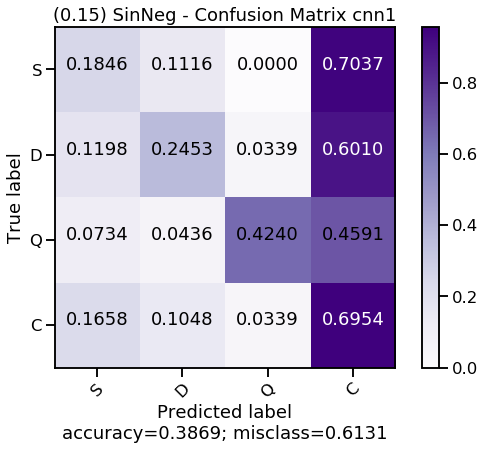

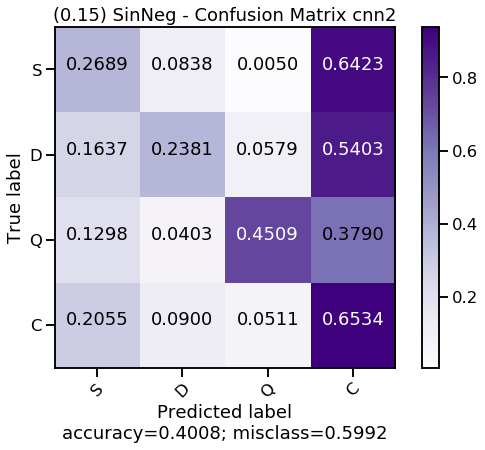

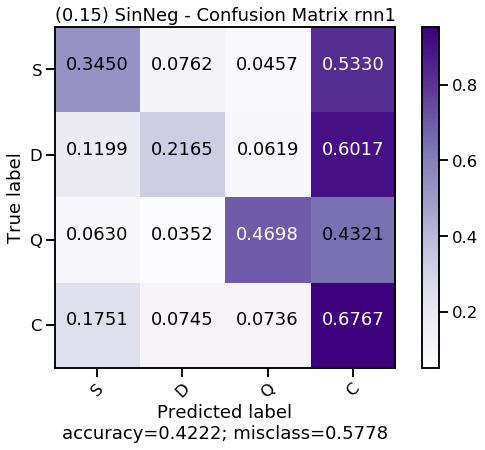

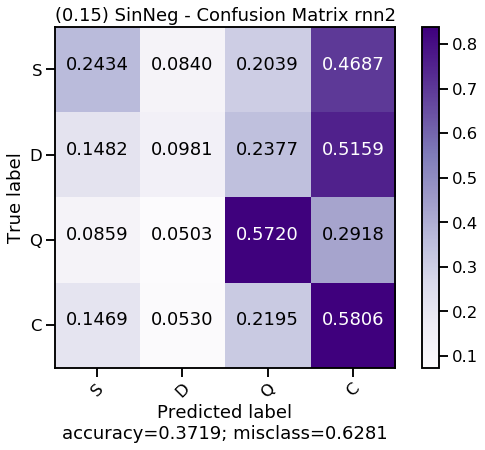

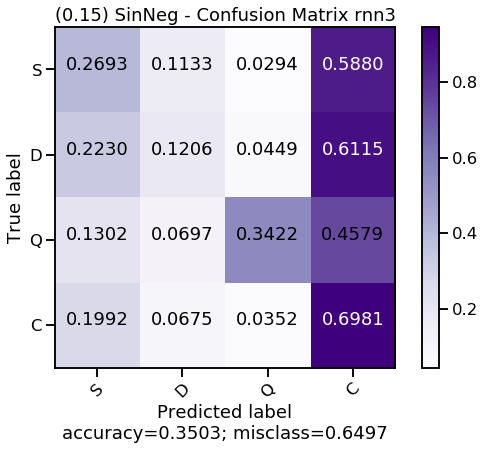

In [21]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/3.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) SinNeg - Confusion Matrix "+str(key), cmap='Purples')

# ANTES

In [36]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/3)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/3, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/3)

(0.15) app1 F1-score promedio para cnn1 : [0.12835608 0.15445032 0.46933411 0.74864095]
(0.15) app1 F1-score promedio para cnn2 : [0.1241117  0.20806337 0.53707269 0.72583336]
(0.15) app1 F1-score promedio para rnn1 : [0.17703091 0.19249027 0.41465492 0.68805439]
(0.15) app1 F1-score promedio para rnn2 : [0.14572875 0.14599015 0.43298112 0.67321037]
(0.15) app1 F1-score promedio para rnn3 : [0.14009931 0.14483935 0.44232435 0.7775823 ]

(0.15) app1 F1-score macro promedio para cnn1 : 0.3751953664546759 desvest:  0.010706004734376457
(0.15) app1 F1-score macro promedio para cnn2 : 0.3987702772292632 desvest:  0.01270442865387074
(0.15) app1 F1-score macro promedio para rnn1 : 0.3680576247872242 desvest:  0.03284402177126346
(0.15) app1 F1-score macro promedio para rnn2 : 0.3494775971551629 desvest:  0.003183891342820671
(0.15) app1 F1-score macro promedio para rnn3 : 0.3762113264256452 desvest:  0.018529454803891232

(0.15) app1 Accuracy promedio para cnn1 : 0.6059418870388509
(0.15) ap

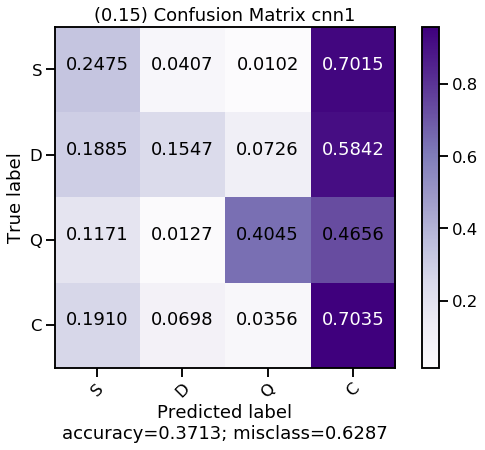

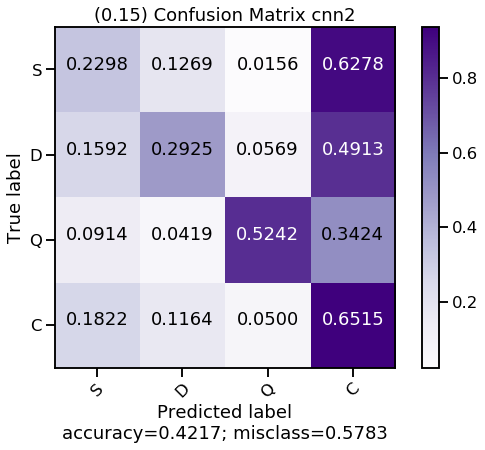

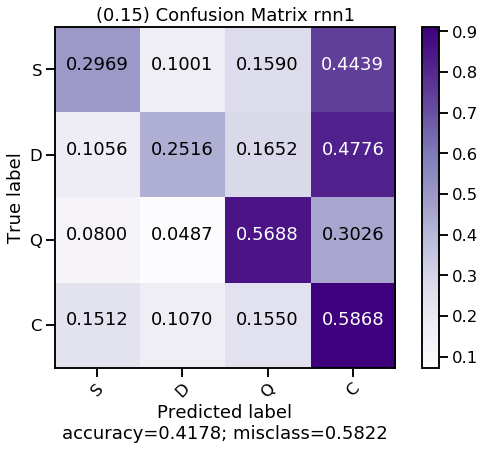

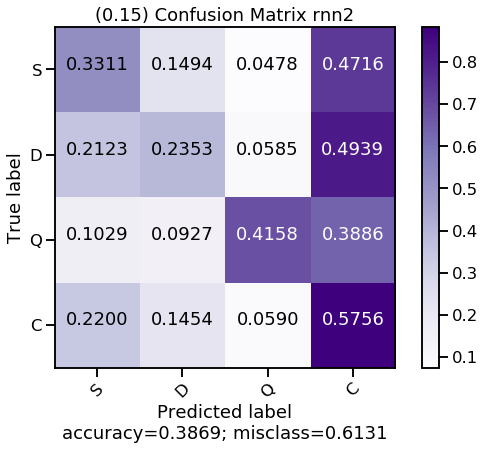

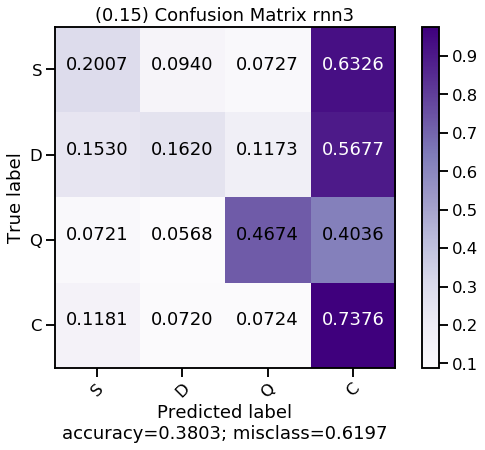

In [37]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/3.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) Confusion Matrix "+str(key), cmap='Purples')

### Generar 3 en stance [positivo + neg si existe]

In [42]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,4): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad SIN SALTO --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../../../new_data_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'_Posible.npy', macro_augmented)
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad SIN SALTO -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'chance', 'that', "'", 's', 'having', 'said', 'for', 'fear', 'of', 'retribution', '?']


Sentencia original:
['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 'won' "'"
 't' 'make' 'it' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'ah', 'sarcastic', '.', 'situation', 'now', 'is', 'we', "'", 'll', 'probably', 'only', 'get', 'coroner', "'", 's', 'details', 'they', 'won', "'", 'man', 'do', 'it', '.']


Sentencia original:
['user' 'user' 'if' 'so' 

# terms modificados promedio 1.8629737609329446 términos por sentencia
Largo de sentencia promedio 21.729279466888798 términos por sentencia
para esta ejecución se debiesen reemplazar 5451  de 36987 terminos
Resumen de modificaciones: {'VBZ': 177, 'NN': 2613, 'VBD': 131, 'VB': 275, 'VBG': 234, 'VBN': 171, 'VBP': 69, 'NNS': 456, 'JJ': 330, 'JJR': 10, 'JJS': 7}
Este proceso tomó 24.945017337799072 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad SIN SALTO -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'clarified', 'that', 'earlier', '.', 'words']


Sentencia original:
['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'de

# terms modificados promedio 1.872136609745939 términos por sentencia
Largo de sentencia promedio 21.663890045814245 términos por sentencia
para esta ejecución se debiesen reemplazar 5473  de 36017 terminos
Resumen de modificaciones: {'NN': 2680, 'JJ': 350, 'VBD': 134, 'VBZ': 183, 'VB': 279, 'VBG': 213, 'NNS': 413, 'VBN': 164, 'VBP': 63, 'JJR': 8, 'JJS': 8}
Este proceso tomó 24.97197651863098 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad SIN SALTO -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:
['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'clarified', 'that', 'earlier', '.', 'words']


Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'us

# terms modificados promedio 1.8263223656809662 términos por sentencia
Largo de sentencia promedio 21.680966264056643 términos por sentencia
para esta ejecución se debiesen reemplazar 5354  de 36000 terminos
Resumen de modificaciones: {'VBZ': 204, 'VBD': 129, 'NN': 2629, 'JJ': 339, 'VB': 258, 'VBP': 58, 'NNS': 430, 'VBN': 141, 'VBG': 184, 'JJS': 7, 'JJR': 6}
Este proceso tomó 24.61608076095581 seg


In [22]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,4):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented= np.load('../../../new_data_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'_Posible.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_Posible/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_Posible/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_Posible/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_Posible/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../../../new_data_augmented/stance_baselines/0.15_Posible/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.96525237746891
F1-score None sobre Train cnn1 : [0.94340344 0.99060254 0.99116022 0.93690579]
F1-score macro sobre Train cnn1 : 0.9655179990891999

Accuracy sobre Val cnn1 : 0.6619217081850534
F1-score None sobre Val cnn1 : [0.5974026  0.28571429 0.60869565 0.74006116]
F1-score macro sobre Val cnn1 : 0.5579684243425768

Accuracy sobre Test cnn1 : 0.6346718903036239
F1-score None sobre Test cnn1 : [0.11428571 0.19607843 0.49438202 0.76882079]
F1-score macro sobre Test cnn1 : 0.39339173856818627

Accuracy sobre Train cnn2 : 0.9738478419897586
F1-score None sobre Train cnn2 : [0.96360936 0.98560354 0.99286368 0.95377476]
F1-score macro sobre Train cnn2 : 0.9739628357017446

Accuracy sobre Val cnn2 : 0.6156583629893239
F1-score None sobre Val cnn2 : [0.54651163 0.32258065 0.61538462 0.68403909]
F1-score macro sobre Val cnn2 : 0.5421289941001912

Accuracy sobre

In [23]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) Posible app1 F1-score promedio para",key,":" ,temp/3)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) Posible app1 F1-score macro promedio para",key,":" ,temp/3, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) Posible app1 Accuracy promedio para",key,":" ,temp/3)

(0.15) Posible app1 F1-score promedio para cnn1 : [0.15399267 0.21975971 0.49629584 0.71843437]
(0.15) Posible app1 F1-score promedio para cnn2 : [0.11766993 0.17295889 0.4959142  0.73341395]
(0.15) Posible app1 F1-score promedio para rnn1 : [0.16722448 0.17992063 0.49377278 0.52702908]
(0.15) Posible app1 F1-score promedio para rnn2 : [0.12996185 0.15966746 0.45596727 0.6392401 ]
(0.15) Posible app1 F1-score promedio para rnn3 : [0.12837786 0.14487314 0.4143562  0.61089607]

(0.15) Posible app1 F1-score macro promedio para cnn1 : 0.3971206473410551 desvest:  0.003659267202911502
(0.15) Posible app1 F1-score macro promedio para cnn2 : 0.37998924207344004 desvest:  0.018397496816838103
(0.15) Posible app1 F1-score macro promedio para rnn1 : 0.3419867406044623 desvest:  0.06642410960757027
(0.15) Posible app1 F1-score macro promedio para rnn2 : 0.34620916832231435 desvest:  0.040424770532312804
(0.15) Posible app1 F1-score macro promedio para rnn3 : 0.32462581801968077 desvest:  0.013335

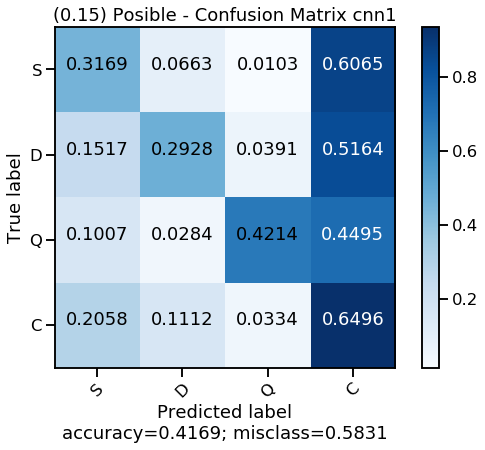

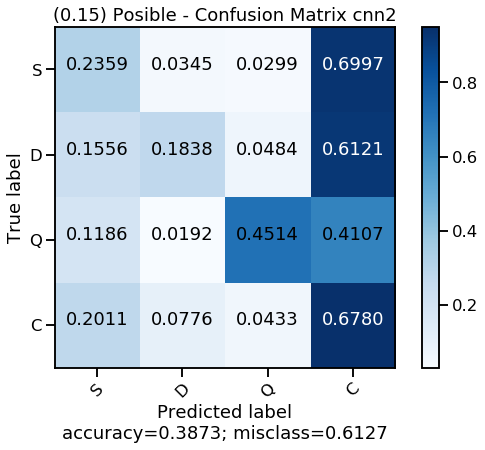

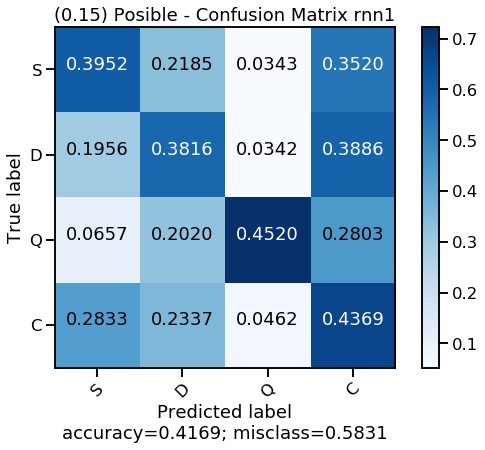

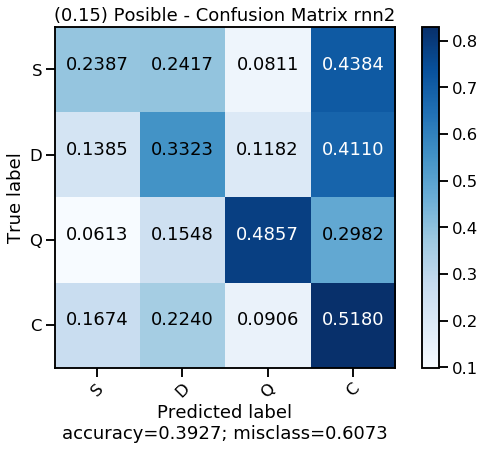

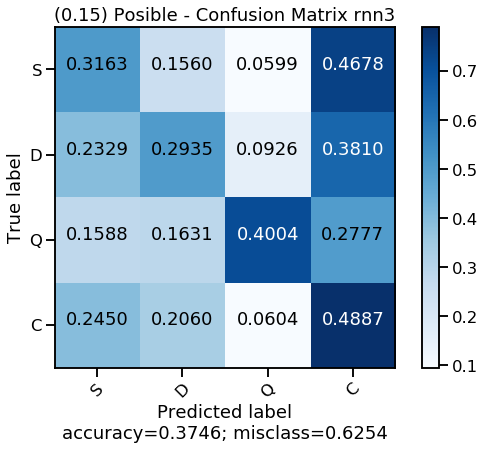

In [24]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/3.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) Posible - Confusion Matrix "+str(key), cmap='Blues')

In [25]:
1+1

2

# Antes (posible)

In [45]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/3)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/3, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/3)

(0.15) app1 F1-score promedio para cnn1 : [0.17816411 0.19829395 0.53910484 0.69459026]
(0.15) app1 F1-score promedio para cnn2 : [0.1138764  0.17066828 0.53415335 0.70992139]
(0.15) app1 F1-score promedio para rnn1 : [0.13318111 0.15601043 0.47417936 0.55522152]
(0.15) app1 F1-score promedio para rnn2 : [0.14254675 0.09672622 0.40248587 0.62931266]
(0.15) app1 F1-score promedio para rnn3 : [0.13039877 0.11269929 0.39898617 0.71933217]

(0.15) app1 F1-score macro promedio para cnn1 : 0.4025382902979054 desvest:  0.00796147146236082
(0.15) app1 F1-score macro promedio para cnn2 : 0.3821548556748064 desvest:  0.006682735594887627
(0.15) app1 F1-score macro promedio para rnn1 : 0.3296481064102124 desvest:  0.015378094701165045
(0.15) app1 F1-score macro promedio para rnn2 : 0.3177678738487217 desvest:  0.009896758722413742
(0.15) app1 F1-score macro promedio para rnn3 : 0.3403541035112283 desvest:  0.027206697961849987

(0.15) app1 Accuracy promedio para cnn1 : 0.5625204048318642
(0.15) a

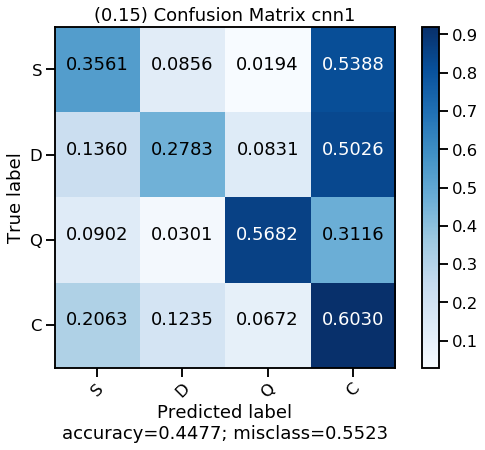

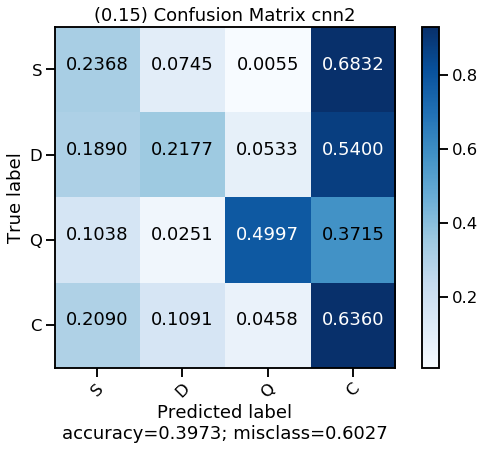

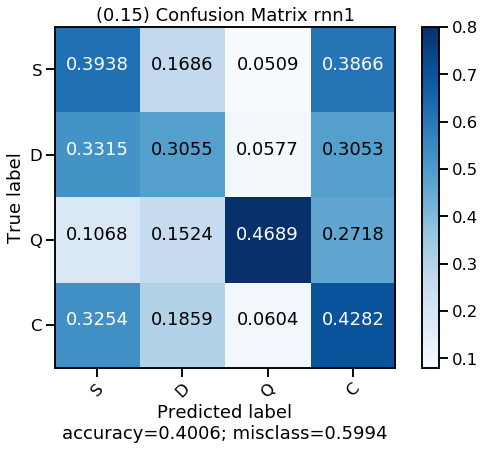

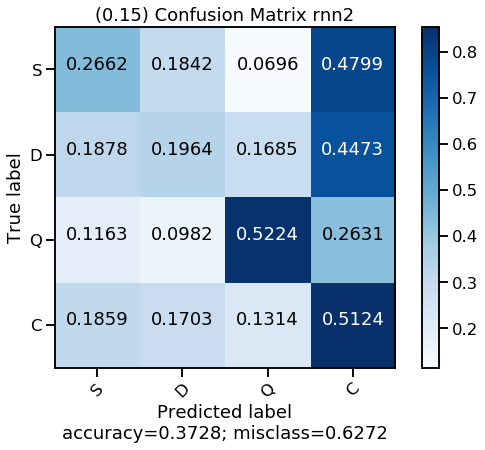

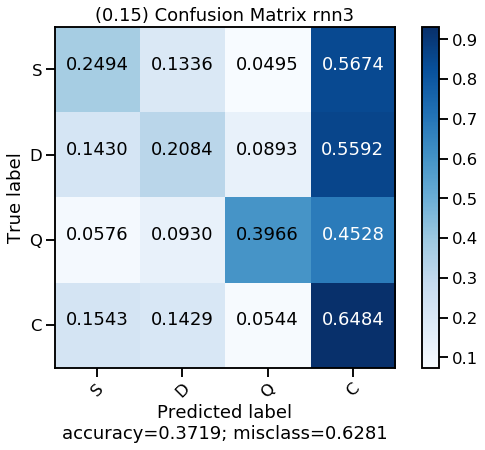

In [46]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/3.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) Confusion Matrix "+str(key), cmap='Blues')

# Sin generar USA CW

In [18]:
train['Tw_id']

0       544296135180169216
1       500454975185879040
2       553210433570881536
3       553593015416008704
4       500393155066626048
               ...        
4233    553570519052980225
4234    500398642167947264
4235    500311506676756480
4236    553506555250106368
4237    576809682947448832
Name: Tw_id, Length: 4238, dtype: int64

In [19]:
d_lab.keys()

dict_keys(['support', 'denying', 'questioning', 'commenting'])

In [20]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)

for sent in sentences:
    encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 768))
j=0
for in_id in input_ids:
    x_train[j]=M_BERT_space[in_id]
    j+=1

Pesos de clases: [1.25980975 3.18168168 3.21060606 0.38752743]


In [21]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0_cw/cnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0_cw/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0_cw/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0_cw/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../../../new_data_augmented/stance_baselines/0.0_cw/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy sobre Train cnn1 : 0.5573383671543181
F1-score None sobre Train cnn1 : [0.5821883  0.3916955  0.58996328 0.59590492]
F1-score macro sobre Train cnn1 : 0.5399379989984201

Accuracy sobre Val cnn1 : 0.26334519572953735
F1-score None sobre Val cnn1 : [0.         0.08510638 0.06666667 0.47445255]
F1-score macro sobre Val cnn1 : 0.1565564010974789

Accuracy sobre Test cnn1 : 0.38491674828599415
F1-score None sobre Test cnn1 : [0.         0.12199037 0.14634146 0.56351792]
F1-score macro sobre Test cnn1 : 0.2079624369763652

Accuracy sobre Train cnn2 : 0.48820198206701276
F1-score None sobre Train cnn2 : [0.59321149 0.35031847 0.47739602 0.4952381 ]
F1-score macro sobre Train cnn2 : 0.4790410191315367

Accuracy sobre Val cnn2 : 0.07473309608540925
F1-score None sobre Val


Accuracy sobre Test rnn3 : 0.791380999020568
F1-score None sobre Test rnn3 : [0.         0.         0.64347826 0.87641791]
F1-score macro sobre Test rnn3 : 0.3799740428293316

Accuracy sobre Train cnn1 : 0.4858423784804153
F1-score None sobre Train cnn1 : [0.58091286 0.3392435  0.56809339 0.48066876]
F1-score macro sobre Train cnn1 : 0.49222962590833486

Accuracy sobre Val cnn1 : 0.24199288256227758
F1-score None sobre Val cnn1 : [0.05194805 0.07446809 0.06896552 0.43283582]
F1-score macro sobre Val cnn1 : 0.15705436879783413

Accuracy sobre Test cnn1 : 0.3819784524975514
F1-score None sobre Test cnn1 : [0.02469136 0.1398374  0.05405405 0.55546559]
F1-score macro sobre Test cnn1 : 0.1935120993743159

Accuracy sobre Train cnn2 : 0.4263803680981595
F1-score None sobre Train cnn2 : [0.56165026 0.3076087  0.52777778 0.37711016]
F1-score macro sobre Train cnn2 : 0.4435367221626023

Accuracy sobre Val cnn2 : 0.23487544483985764
F1-score None sobre Val cnn2 : [0.43010753 0.08571429 0.1333333

In [22]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.0_CW) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.0_CW) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.0_CW) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0_CW) app1 F1-score promedio para cnn1 : [0.0579864  0.09188452 0.08519673 0.72040643]
(0.0_CW) app1 F1-score promedio para cnn2 : [0.09686881 0.06848163 0.0924635  0.48793061]
(0.0_CW) app1 F1-score promedio para rnn1 : [0.00701754 0.15400944 0.61928292 0.42136623]
(0.0_CW) app1 F1-score promedio para rnn2 : [0.05285603 0.11663233 0.58788018 0.4715117 ]
(0.0_CW) app1 F1-score promedio para rnn3 : [0.         0.         0.62241864 0.87541832]

(0.0_CW) app1 F1-score macro promedio para cnn1 : 0.23886851944039017 desvest:  0.03778655369013227
(0.0_CW) app1 F1-score macro promedio para cnn2 : 0.18643613926076869 desvest:  0.08690368166293588
(0.0_CW) app1 F1-score macro promedio para rnn1 : 0.3004190344063701 desvest:  0.06250552349280104
(0.0_CW) app1 F1-score macro promedio para rnn2 : 0.30722005812565906 desvest:  0.04420745227383379
(0.0_CW) app1 F1-score macro promedio para rnn3 : 0.3744592410444601 desvest:  0.0068169754964833365

(0.0_CW) app1 Accuracy promedio para cnn1 : 0.57

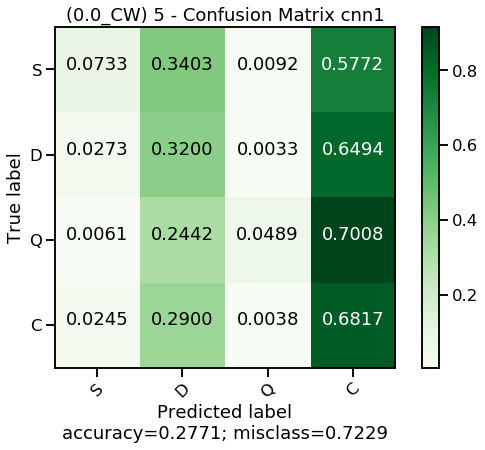

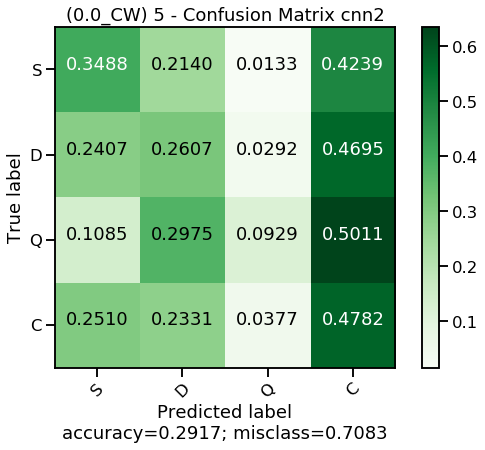

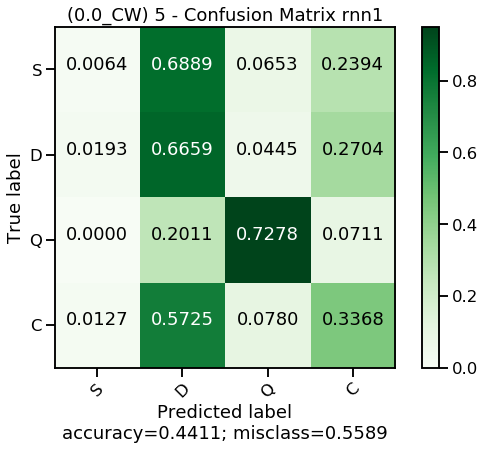

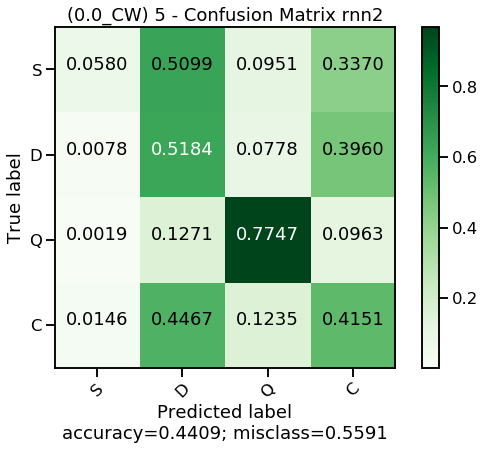

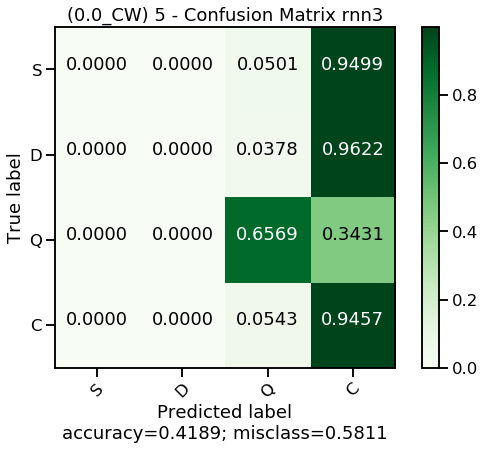

In [23]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0_CW) 5 - Confusion Matrix "+str(key), cmap='Greens')

### Sin generar con nuevo preprocesamiento SIN CW

In [24]:
class_weights=np.asarray([1.,1.,1.,1.])

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0/cnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../../../new_data_augmented/stance_baselines/0.0/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../../../new_data_augmented/stance_baselines/0.0/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)



Accuracy sobre Train cnn1 : 0.7208588957055214
F1-score None sobre Train cnn1 : [0.59705882 0.0119403  0.06997085 0.8185772 ]
F1-score macro sobre Train cnn1 : 0.37438679135136665

Accuracy sobre Val cnn1 : 0.6156583629893239
F1-score None sobre Val cnn1 : [0.         0.         0.         0.76211454]
F1-score macro sobre Val cnn1 : 0.1905286343612335

Accuracy sobre Test cnn1 : 0.761998041136141
F1-score None sobre Test cnn1 : [0.         0.         0.         0.86492496]
F1-score macro sobre Test cnn1 : 0.2162312395775431

Accuracy sobre Train cnn2 : 0.7243983010854177
F1-score None sobre Train cnn2 : [0.60132646 0.0119403  0.08139535 0.82173913]
F1-score macro sobre Train cnn2 : 0.3791003082989536

Accuracy sobre Val cnn2 : 0.6156583629893239
F1-score None sobre Val cnn2 : [0.         0.         0.         0.76211454]
F1-score macro sobre Val cnn2 : 0.1905286343612335

Accuracy sobre Test cnn2 : 0.761998041136141
F1-score None sobre Test cnn2 : [0.         0.         0.         0.8


Accuracy sobre Test cnn1 : 0.761998041136141
F1-score None sobre Test cnn1 : [0.         0.         0.         0.86492496]
F1-score macro sobre Test cnn1 : 0.2162312395775431

Accuracy sobre Train cnn2 : 0.7154318074563474
F1-score None sobre Train cnn2 : [0.59779614 0.         0.08139535 0.81424295]
F1-score macro sobre Train cnn2 : 0.37335861037820584

Accuracy sobre Val cnn2 : 0.6156583629893239
F1-score None sobre Val cnn2 : [0.         0.         0.         0.76211454]
F1-score macro sobre Val cnn2 : 0.1905286343612335

Accuracy sobre Test cnn2 : 0.761998041136141
F1-score None sobre Test cnn2 : [0.         0.         0.         0.86492496]
F1-score macro sobre Test cnn2 : 0.2162312395775431

Accuracy sobre Train rnn1 : 0.7619159981123171
F1-score None sobre Train rnn1 : [0.66182299 0.35448578 0.51004016 0.83902114]
F1-score macro sobre Train rnn1 : 0.5913425162294443

Accuracy sobre Val rnn1 : 0.6512455516014235
F1-score None sobre Val rnn1 : [0.         0.         0.62295082 0.

In [25]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.0) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.0) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.0) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0) app1 F1-score promedio para cnn1 : [0.         0.         0.         0.86492496]
(0.0) app1 F1-score promedio para cnn2 : [0.01860465 0.         0.         0.86352896]
(0.0) app1 F1-score promedio para rnn1 : [0.         0.         0.59848528 0.87801001]
(0.0) app1 F1-score promedio para rnn2 : [0.         0.         0.54564563 0.87477979]
(0.0) app1 F1-score promedio para rnn3 : [0.         0.         0.59781114 0.87514975]

(0.0) app1 F1-score macro promedio para cnn1 : 0.21623123957754312 desvest:  2.7755575615628914e-17
(0.0) app1 F1-score macro promedio para cnn2 : 0.22053340318939693 desvest:  0.008604327223707697
(0.0) app1 F1-score macro promedio para rnn1 : 0.36912382185173725 desvest:  0.018742483490652925
(0.0) app1 F1-score macro promedio para rnn2 : 0.35510635524627915 desvest:  0.029831913553161823
(0.0) app1 F1-score macro promedio para rnn3 : 0.36824022073094576 desvest:  0.025761925055331442

(0.0) app1 Accuracy promedio para cnn1 : 0.761998041136141
(0.0) app1 A

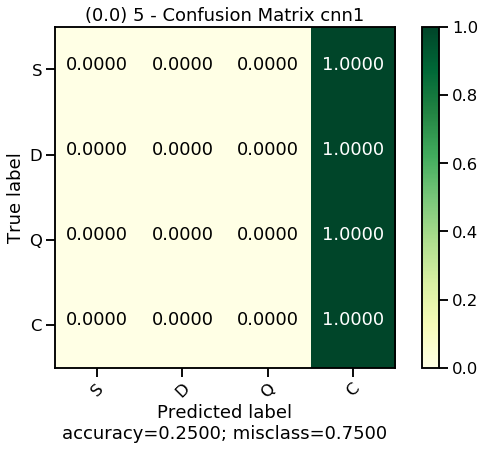

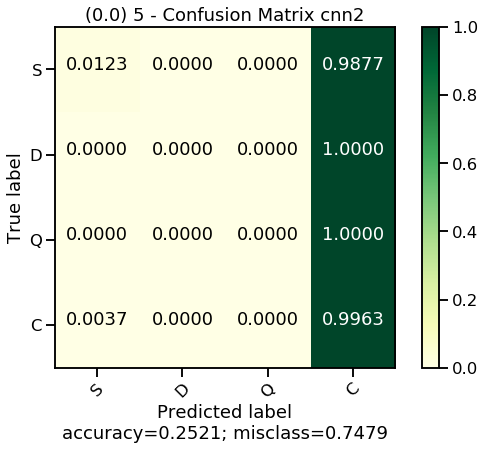

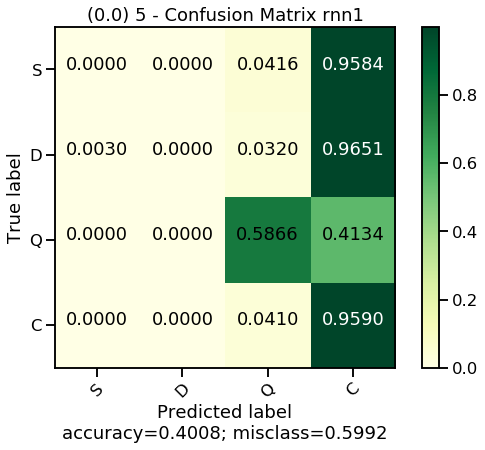

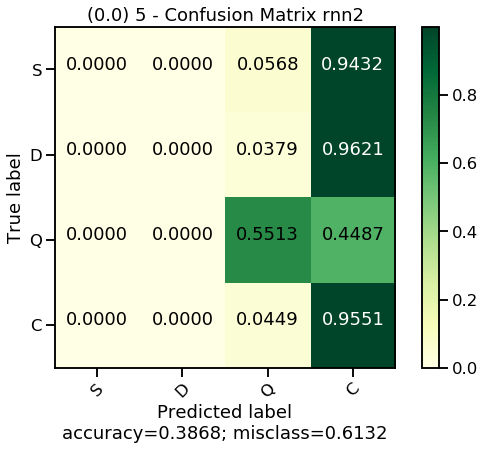

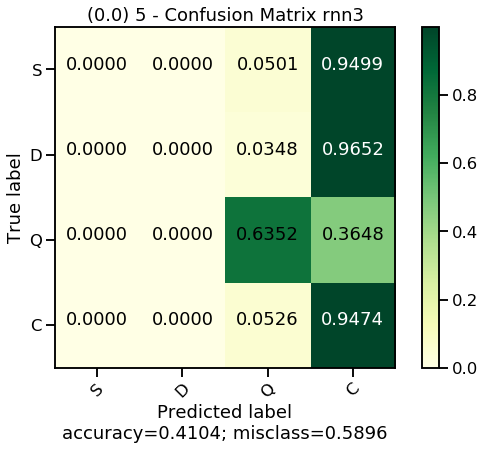

In [27]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0) 5 - Confusion Matrix "+str(key), cmap='YlGn')